## Serial LETK Filtering


In [1]:
import Simulator
import Observation
import Statistics

import KalmanFilter
import ETKalmanFilter
import SLETKalmanFilter
import IEWParticleFilter

import Comparer

## Loading simulator 

For Kalman filtering we have to be able to propagate a Gaussian distribution in time and to have access to the linear operators

In [2]:
timestamp = "2021_08_26-12_22_18"

grid, simulator = Simulator.from_file(timestamp)

## Loading observations 

Observation positions which are fixed for a setup and values from the truth

In [3]:
obs_timestamp = "2021_08_26-12_22_28"
observation = Observation.from_file(grid, timestamp, obs_timestamp)

Remember to set observation positions and to set/observe values!


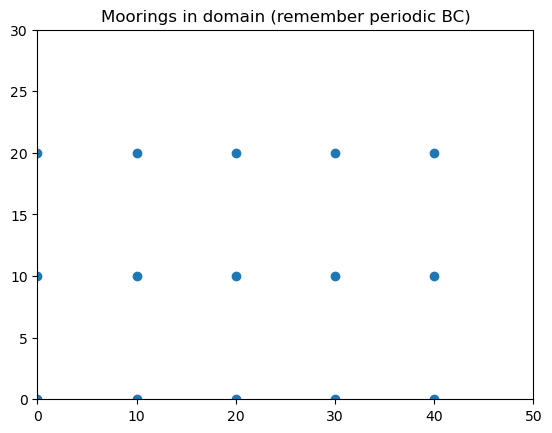

In [4]:
observation.plot_positions()

## Definition of initial distribution 

The inital state is equipped with a Gaussian distribution specified by its mean and covariance. 

In [5]:
prior_args = Statistics.prior_args_from_file(timestamp)

## New truth if changes intended

In [6]:
new_truth = False

In [7]:
if new_truth:
    observation.clear_observations()
    observation.set_regular_positions(10)
    observation.plot_positions()

    statistics_truth = Statistics.Statistics(simulator, 1)
    statistics_truth.set_prior(prior_args)

    for t in range(10):
        statistics_truth.propagate(25)
        statistics_truth.plot()
        observation.observe(statistics_truth.mean)

## Kalman filtering

Updating/conditioning the distributions at every observation time

Please remember to set priors!


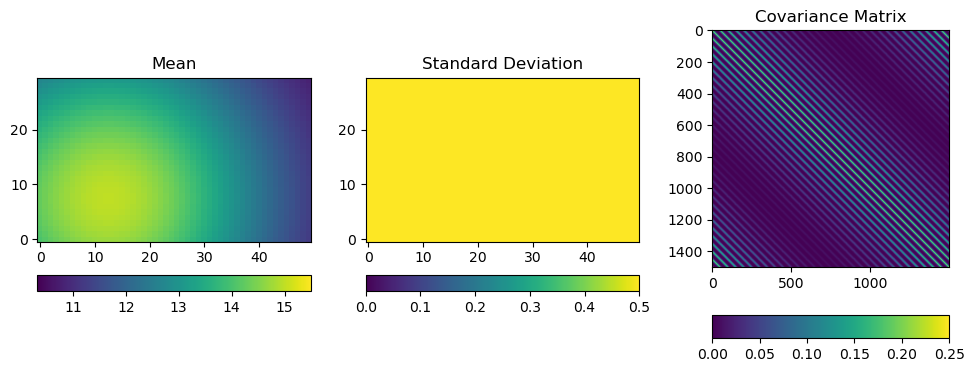

In [8]:
statistics_kf = Statistics.Statistics(simulator)
statistics_kf.set_prior(prior_args)

statistics_kf.plot()

0


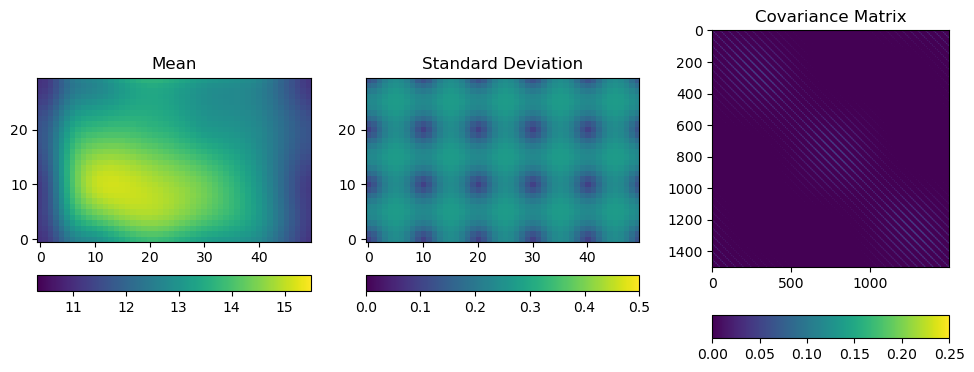

1


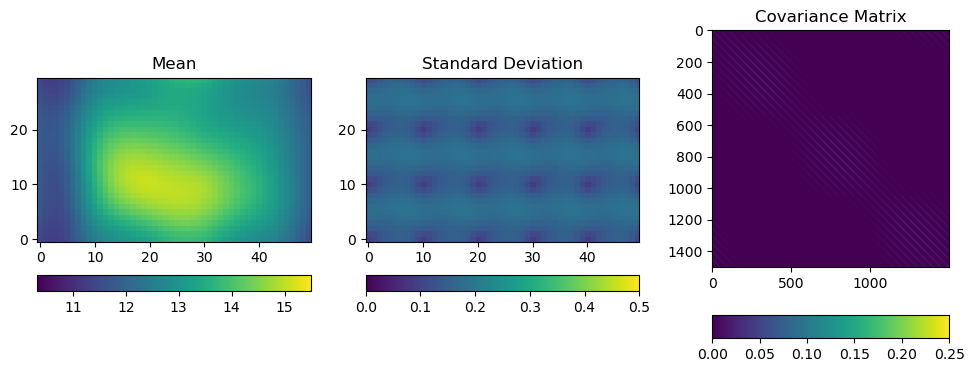

2


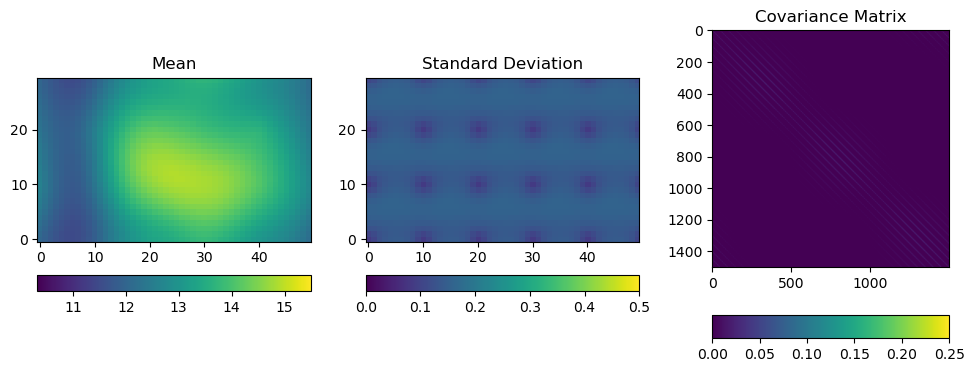

3


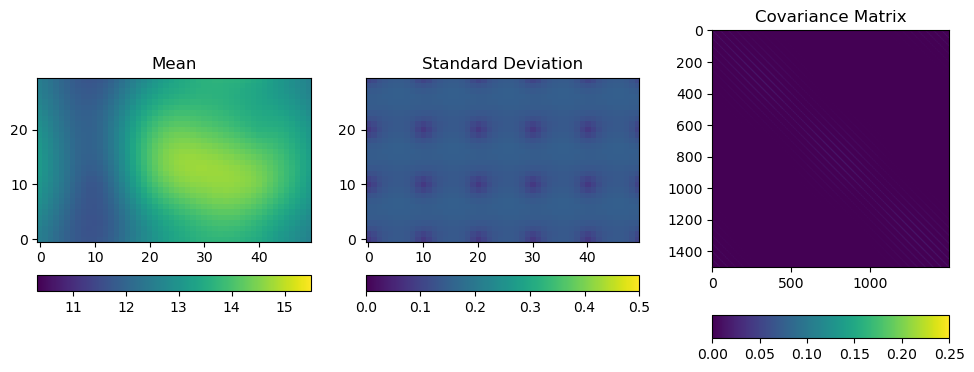

4


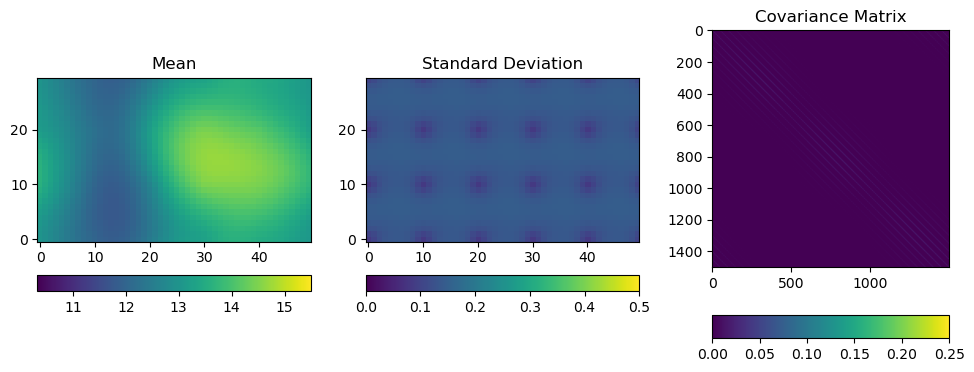

5


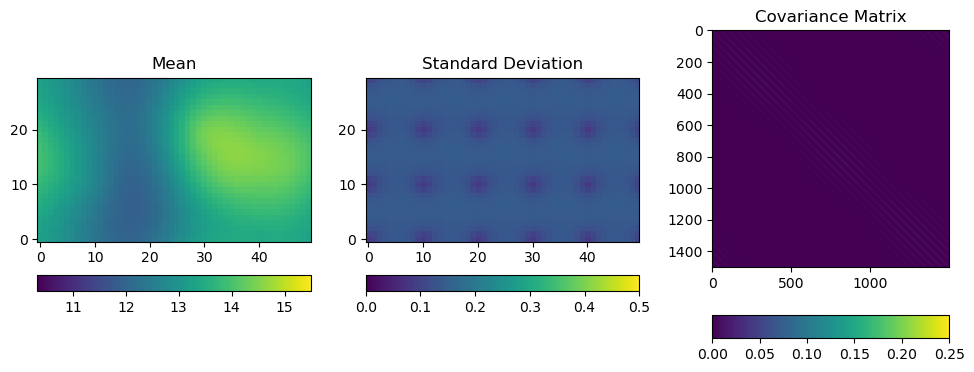

6


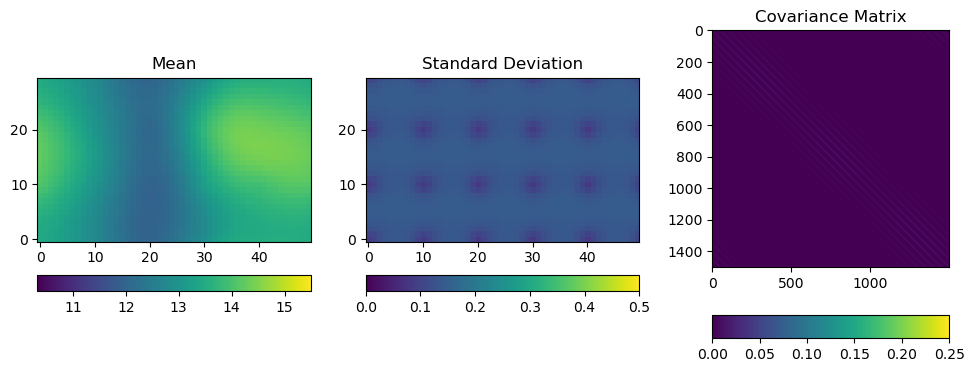

7


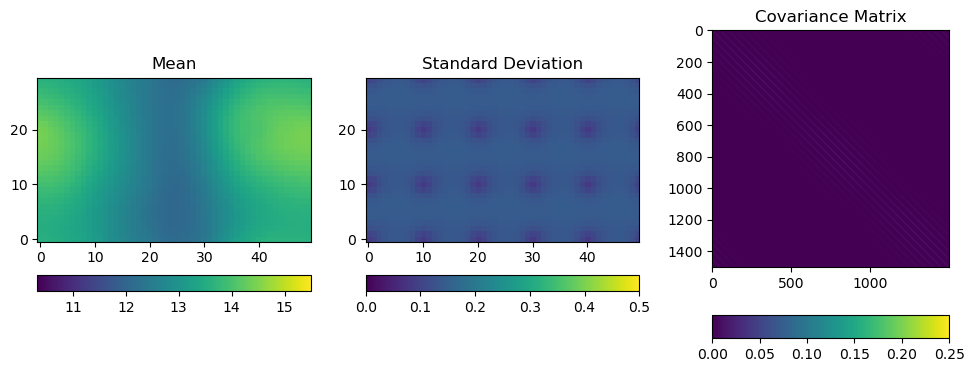

8


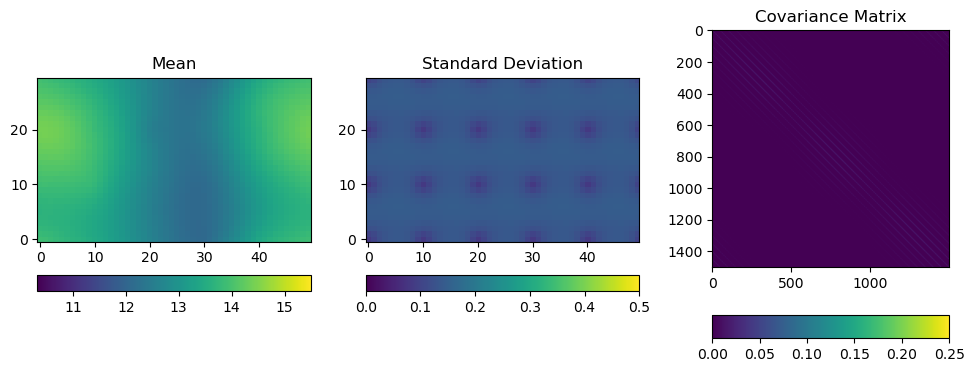

9


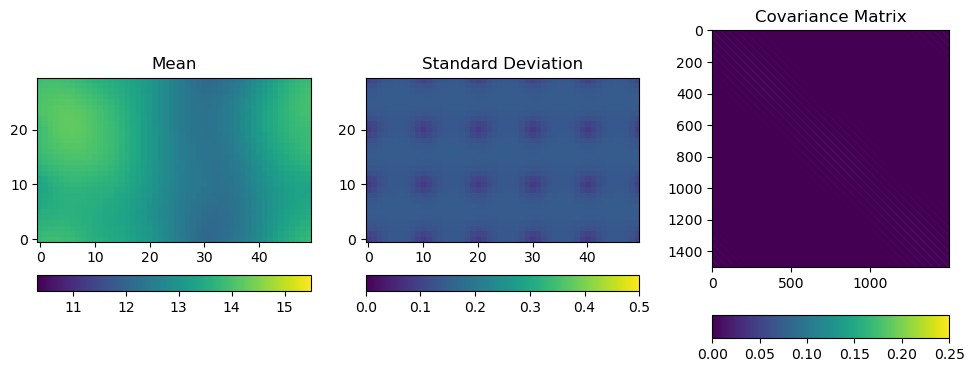

In [9]:
kalmanFilter = KalmanFilter.Kalman(statistics_kf, observation)

for t in range(observation.N_obs):
    print(t)
    statistics_kf.propagate(25)
    kalmanFilter.filter(statistics_kf.mean, statistics_kf.cov, observation.obses[t])
    statistics_kf.plot()

## ETKF filtering

Updating/conditioning the distributions at every observation time

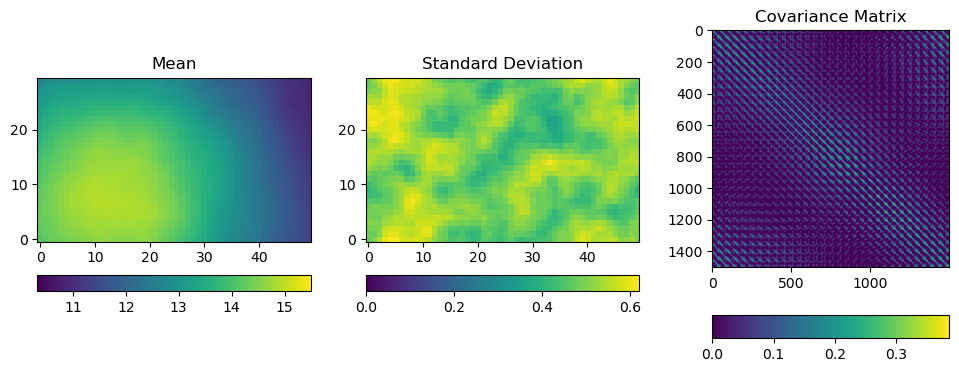

In [10]:
statistics_etkf = Statistics.Statistics(simulator, 50)
statistics_etkf.set_prior(prior_args)

statistics_etkf.plot()

0


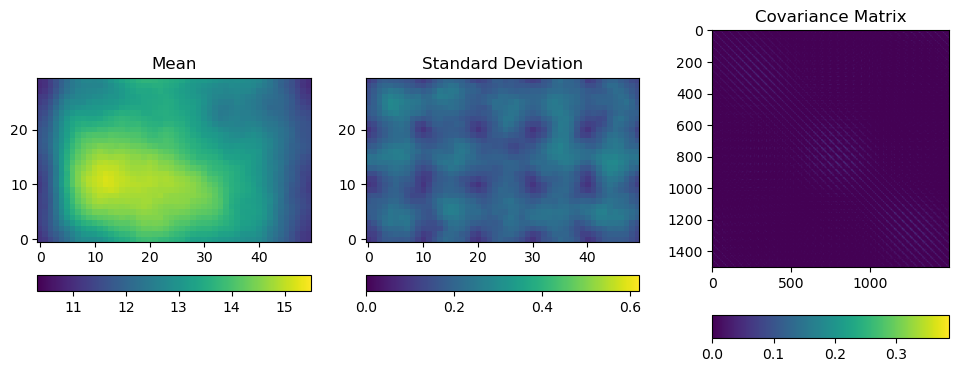

1


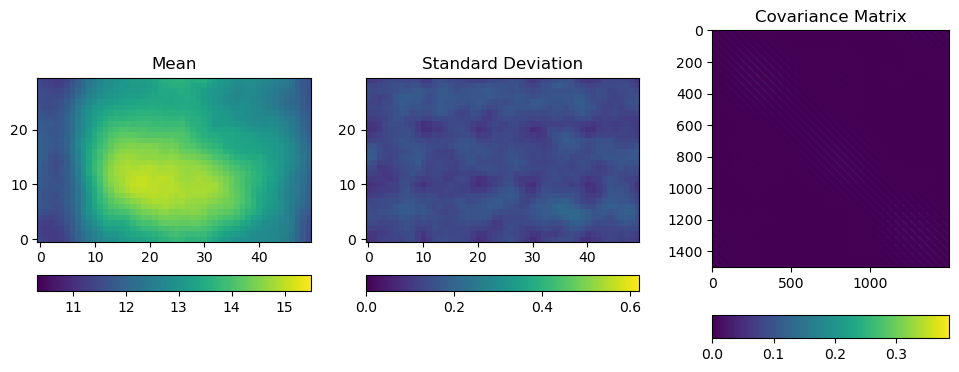

2


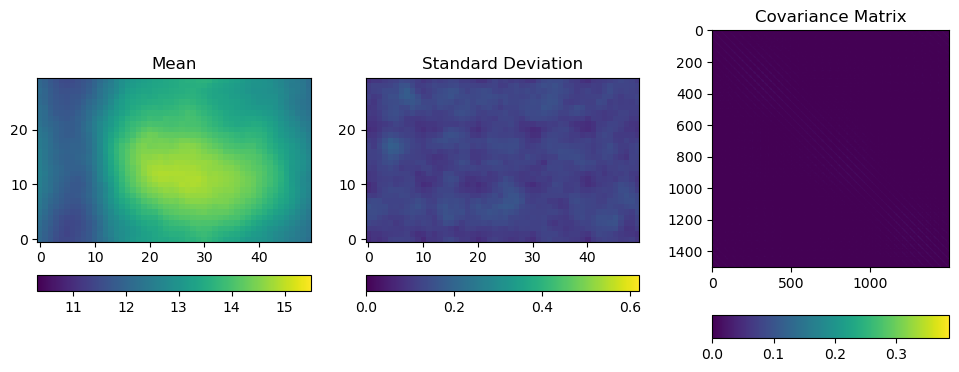

3


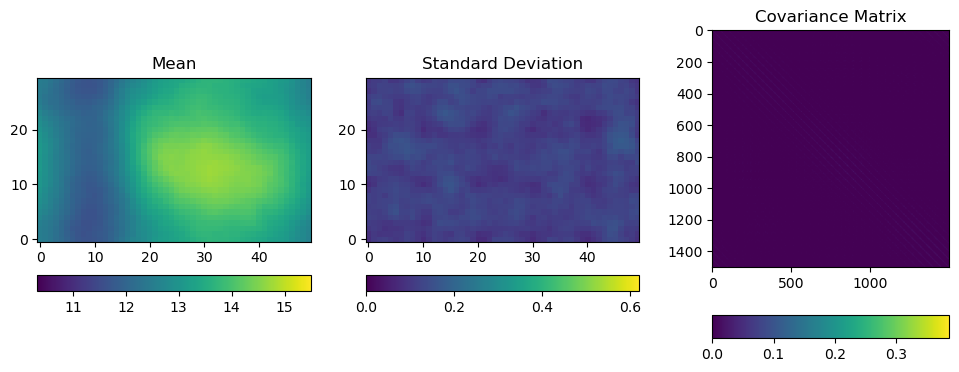

4


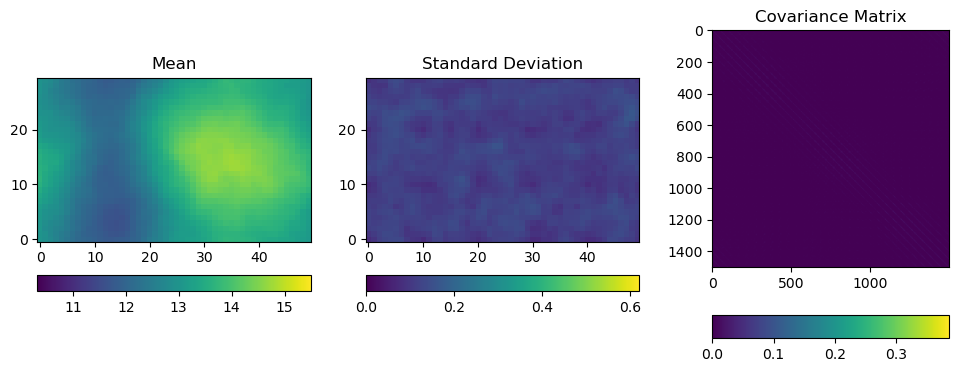

5


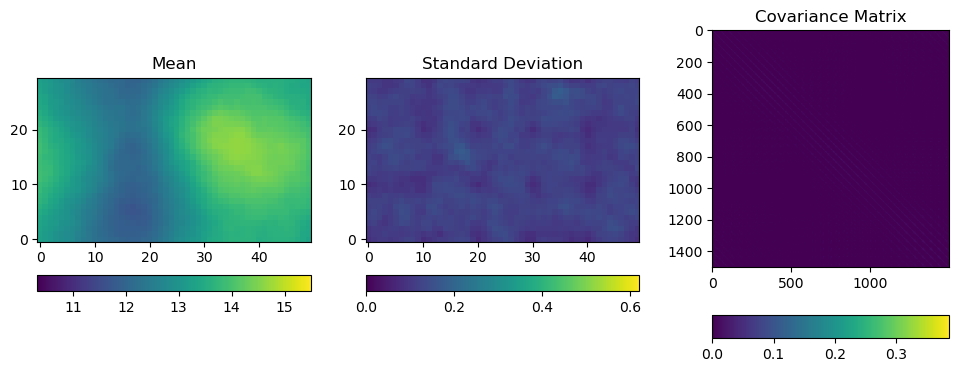

6


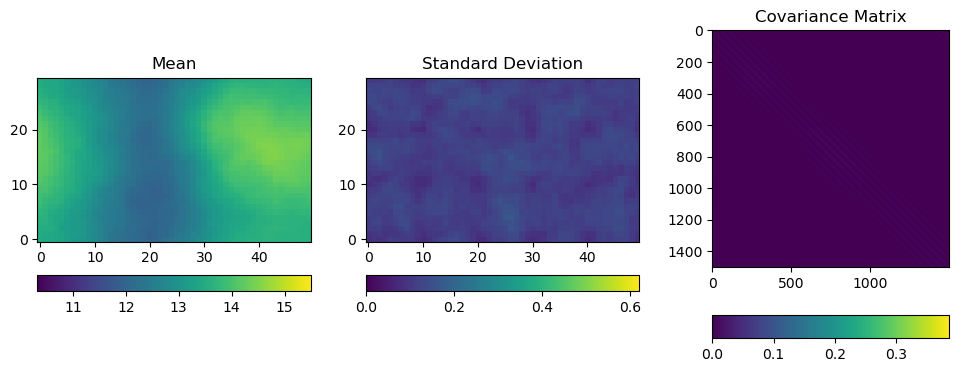

7


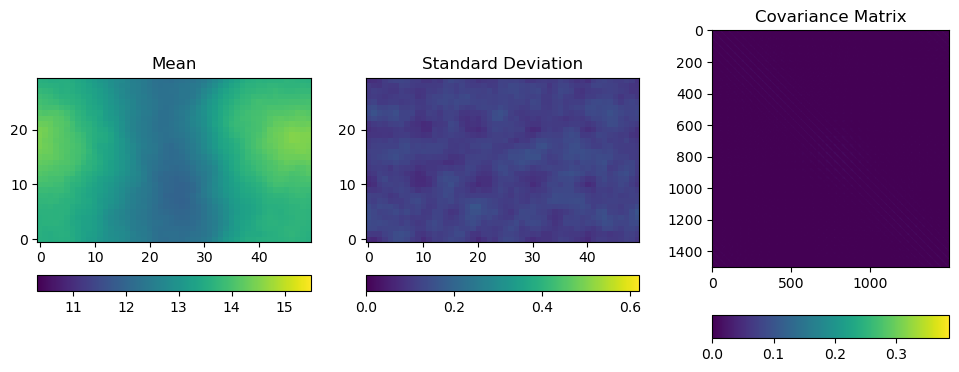

8


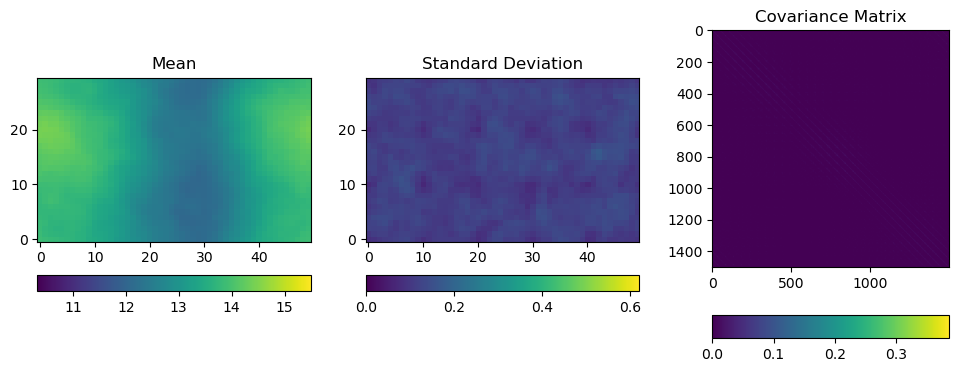

9


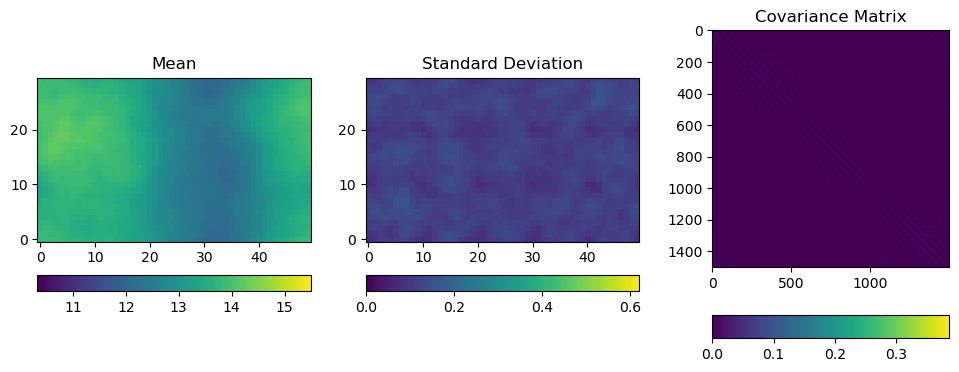

In [11]:
etkFilter = ETKalmanFilter.ETKalman(statistics_etkf, observation)

for t in range(observation.N_obs):
    print(t)
    statistics_etkf.propagate(25)
    etkFilter.filter(statistics_etkf.ensemble.ensemble, observation.obses[t])
    statistics_etkf.plot()

## LETKF filtering

Updating/conditioning the distributions at every observation time

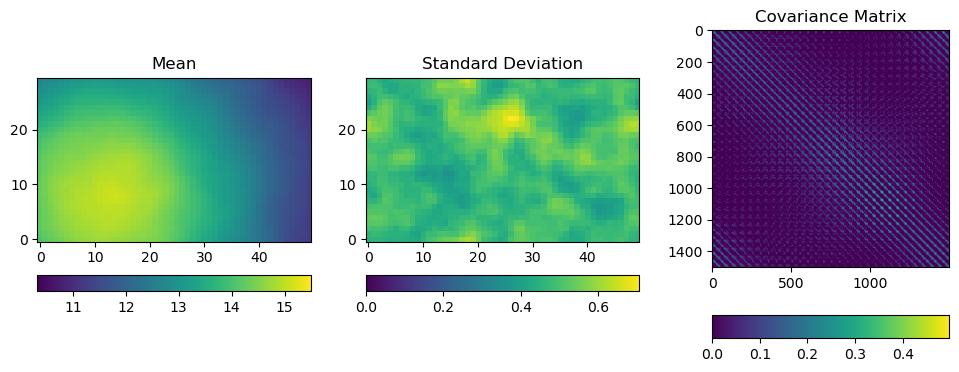

In [12]:
statistics_letkf = Statistics.Statistics(simulator, 50)
statistics_letkf.set_prior(prior_args)

statistics_letkf.plot()

In [13]:
# We choose the scale_r as about 2/3 of the correlation length in grid cells 
scale_r = 8

In [14]:
sletkFilter = SLETKalmanFilter.SLETKalman(statistics_letkf, observation, scale_r)

In [15]:
sletkFilter.groups

[[0, 2, 6, 8, 14], [1, 4, 5, 7, 13], [11, 3, 9], [10, 12]]

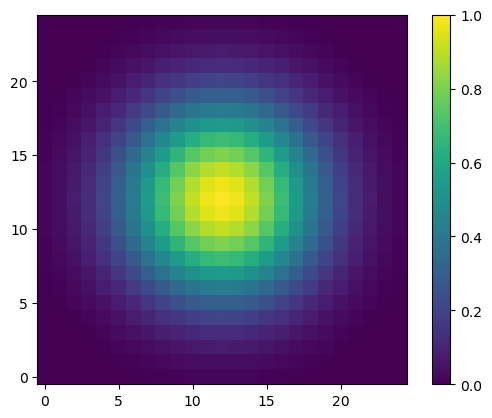

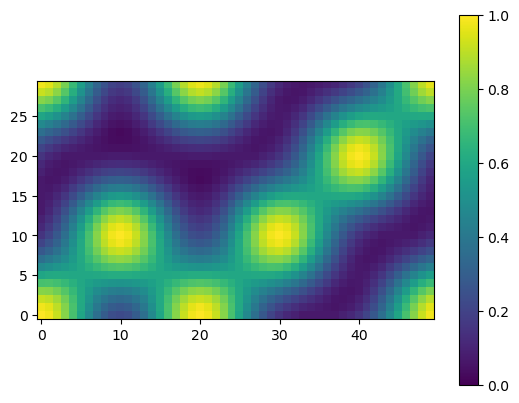

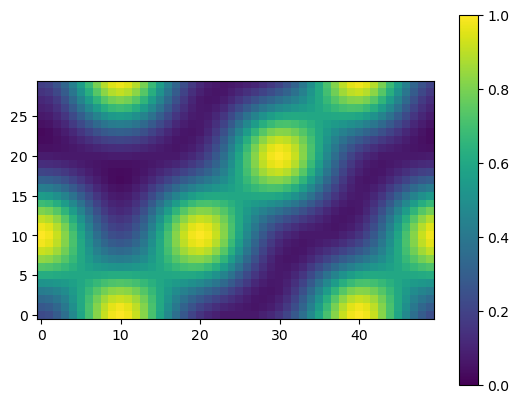

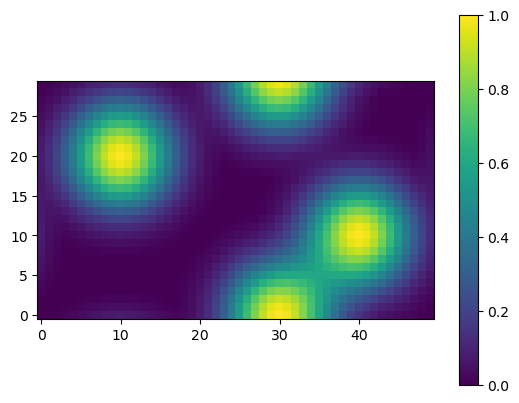

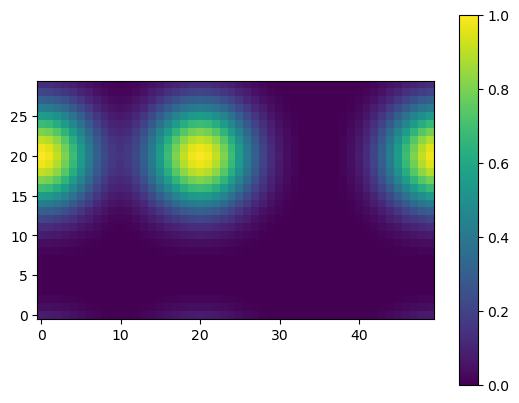

In [16]:
from matplotlib import pyplot as plt
plt.imshow(sletkFilter.W_loc, origin="lower", vmin=0.0, vmax=1.0)
plt.colorbar()
plt.show()
for g in range(len(sletkFilter.groups)):
    plt.imshow(sletkFilter.W_analyses[g], origin="lower", vmin=0.0, vmax=1.0)
    plt.colorbar()
    plt.show()

0


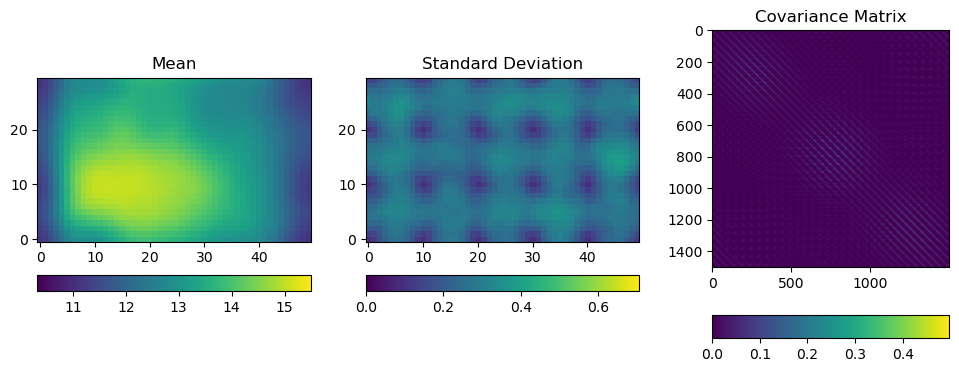

1


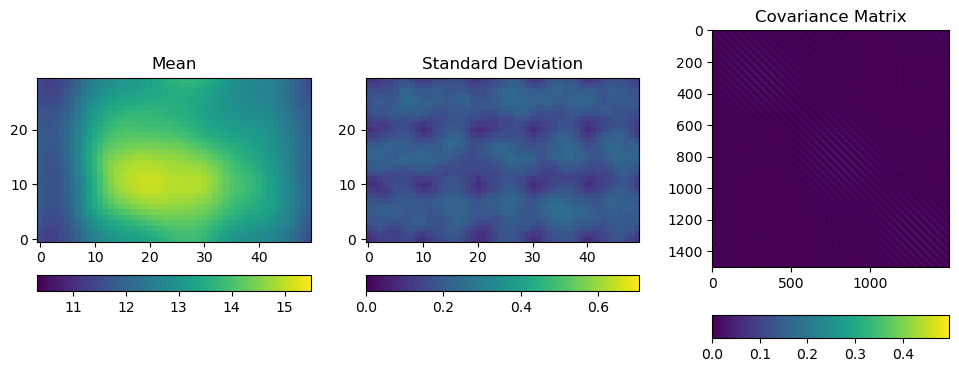

2


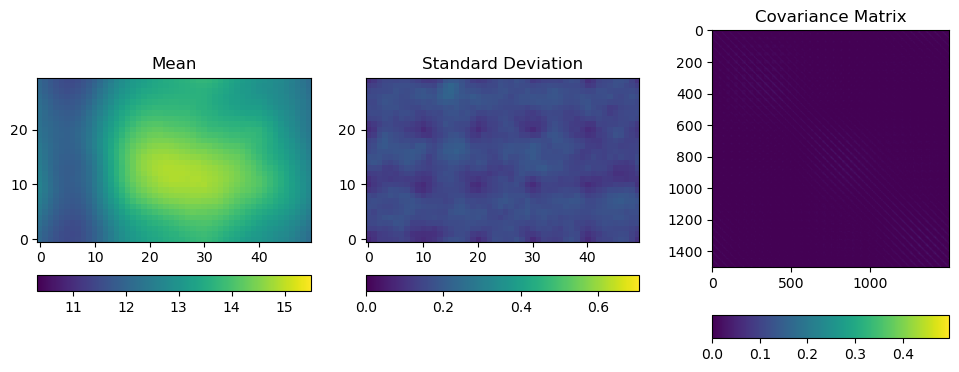

3


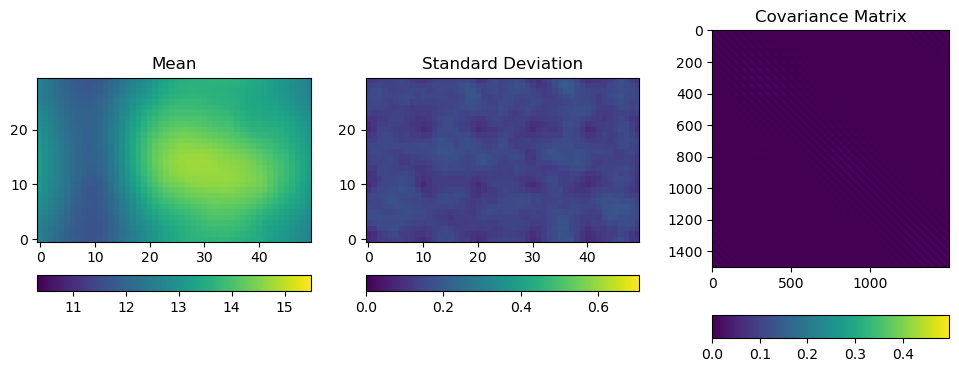

4


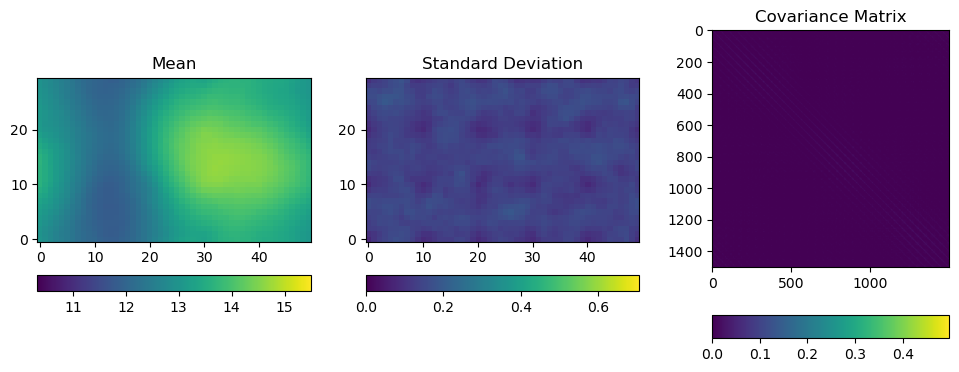

5


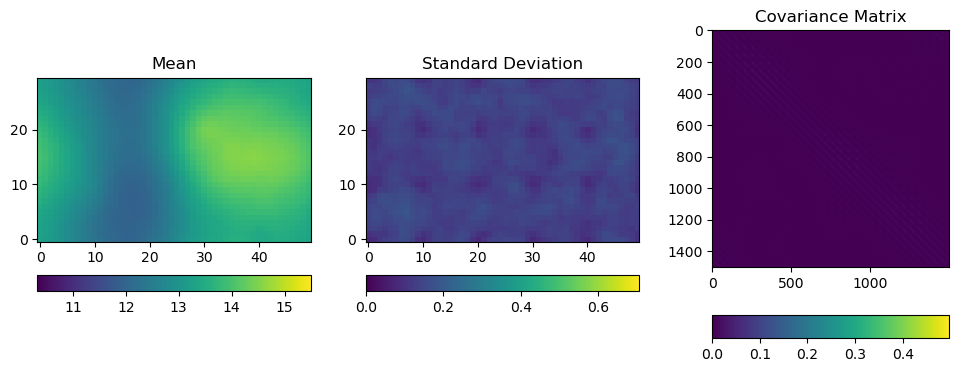

6


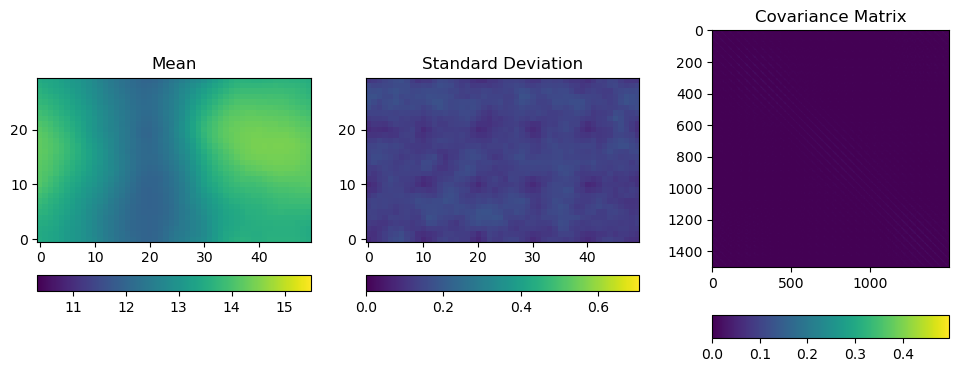

7


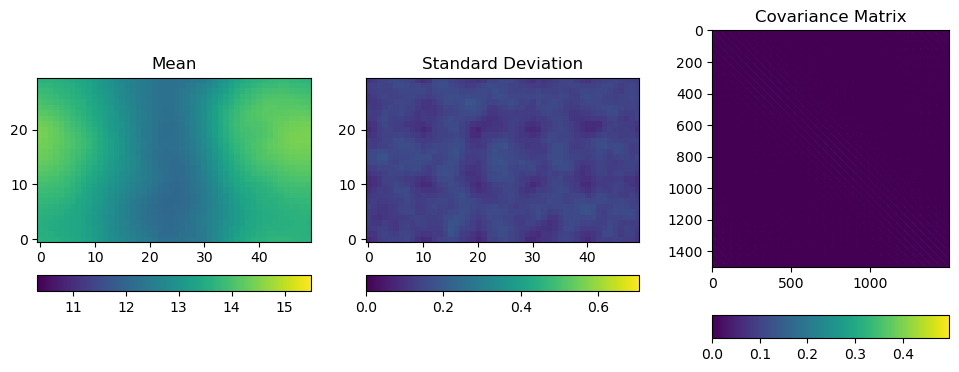

8


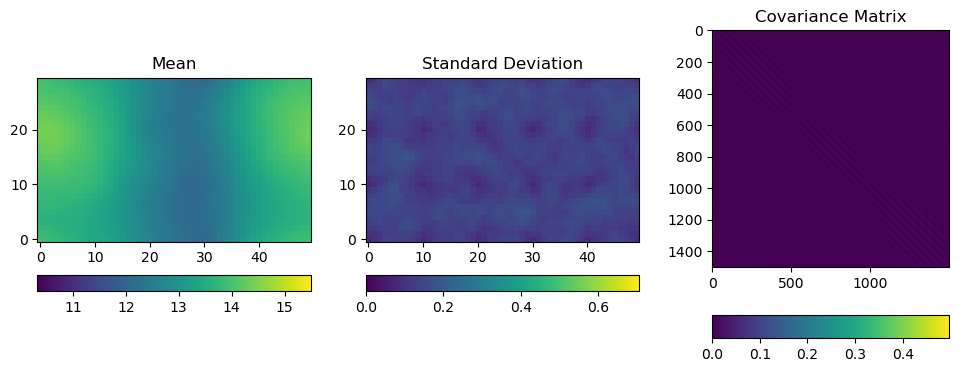

9


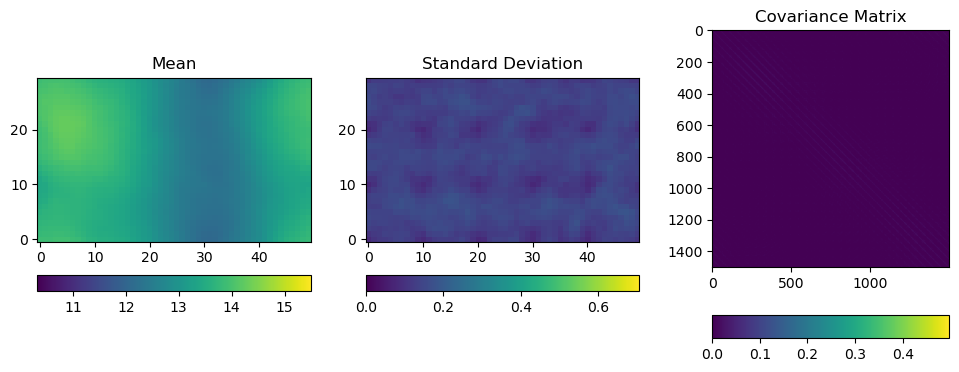

In [17]:
for t in range(observation.N_obs):
    print(t)
    statistics_letkf.propagate(25)
    sletkFilter.filter(statistics_letkf.ensemble.ensemble, observation.obses[t])
    statistics_letkf.plot()

## IEWPF filtering

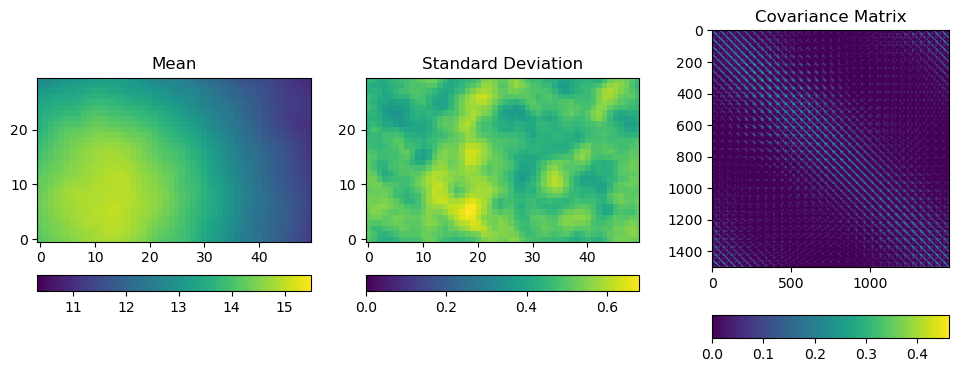

In [18]:
statistics_iewpf = Statistics.Statistics(simulator, 50)
statistics_iewpf.set_prior(prior_args)

statistics_iewpf.plot()

0


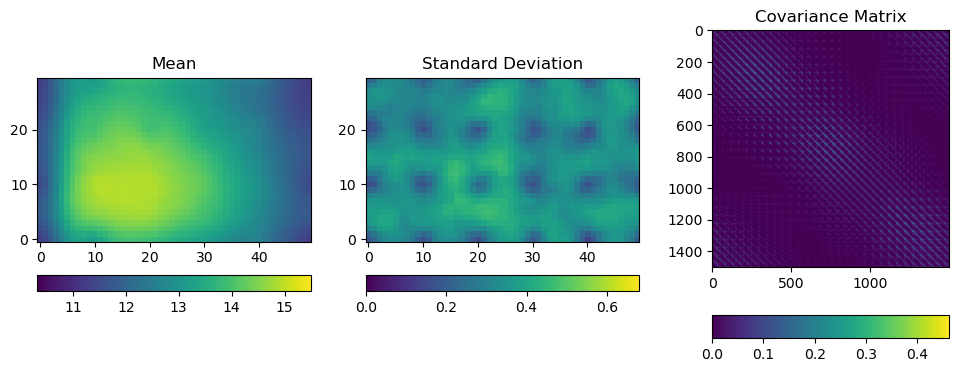

1


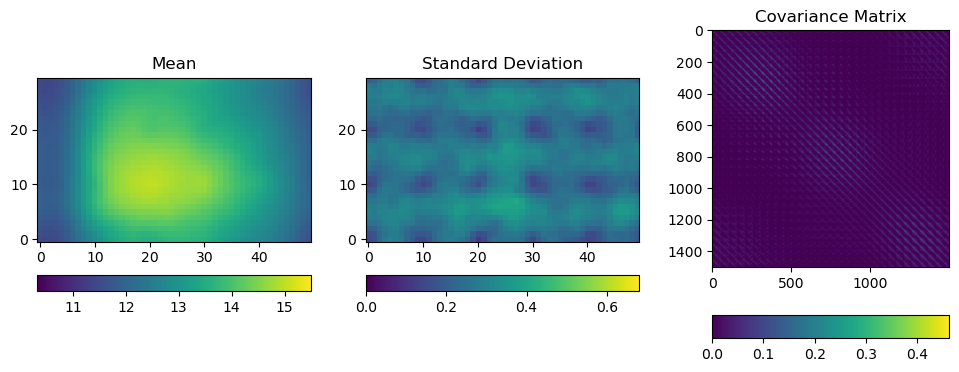

2


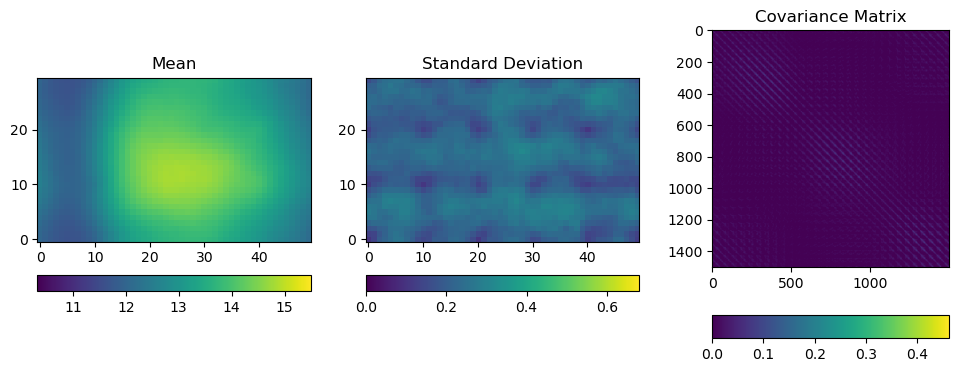

3


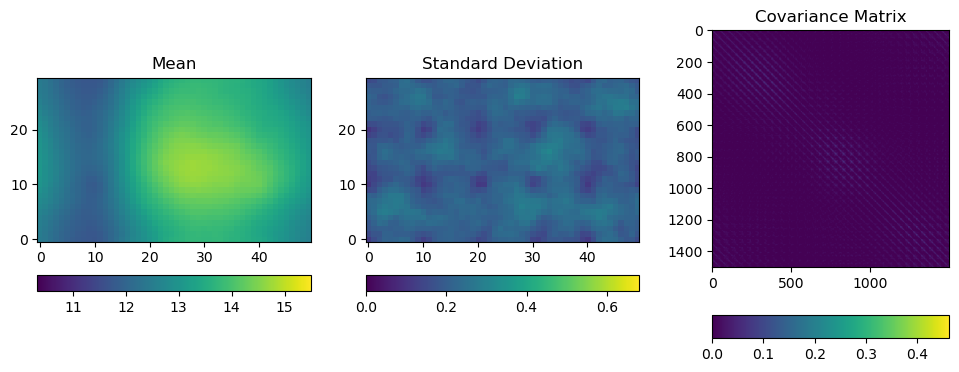

4


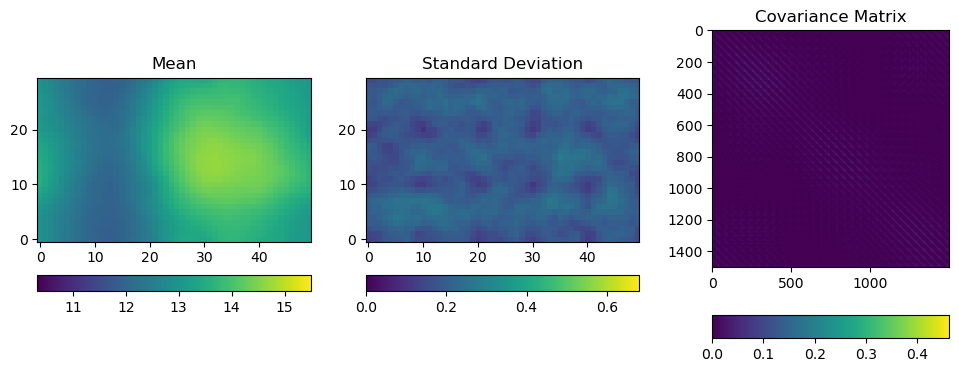

5


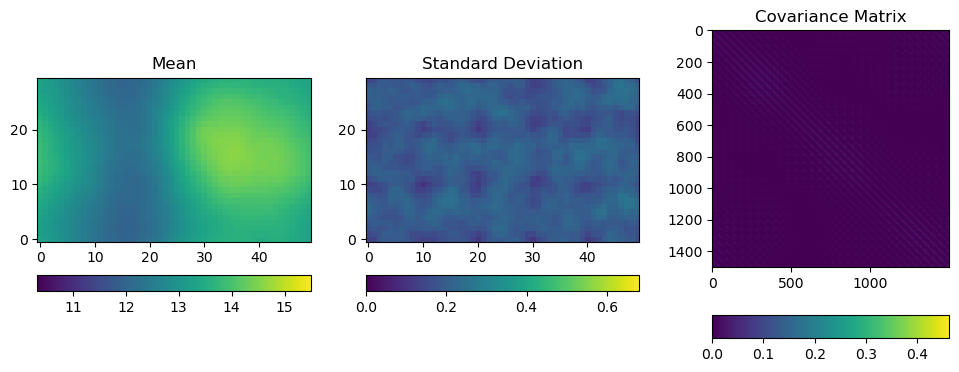

6


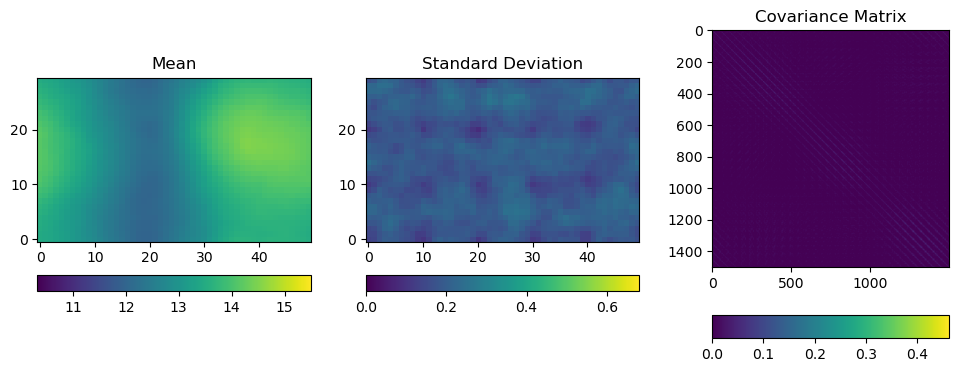

7


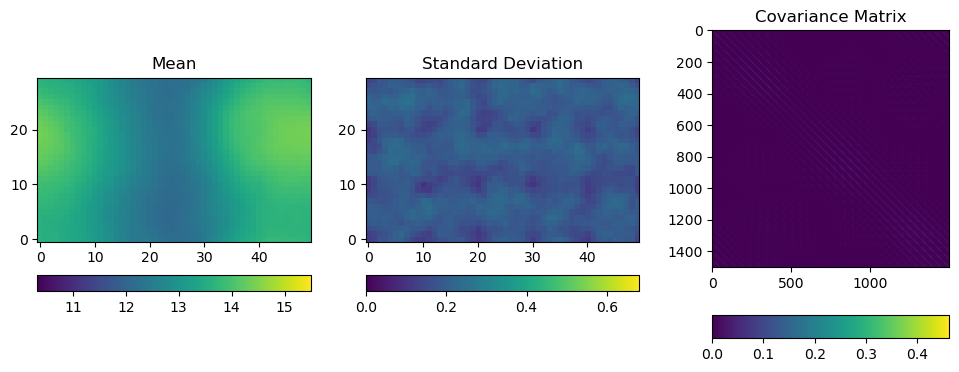

8


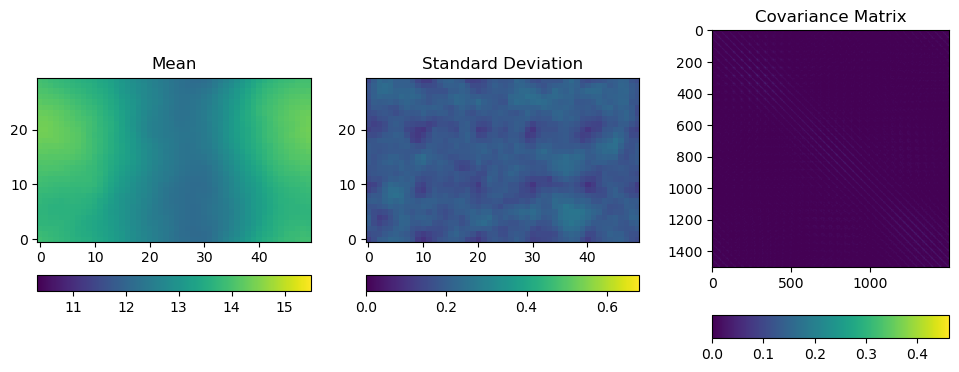

9


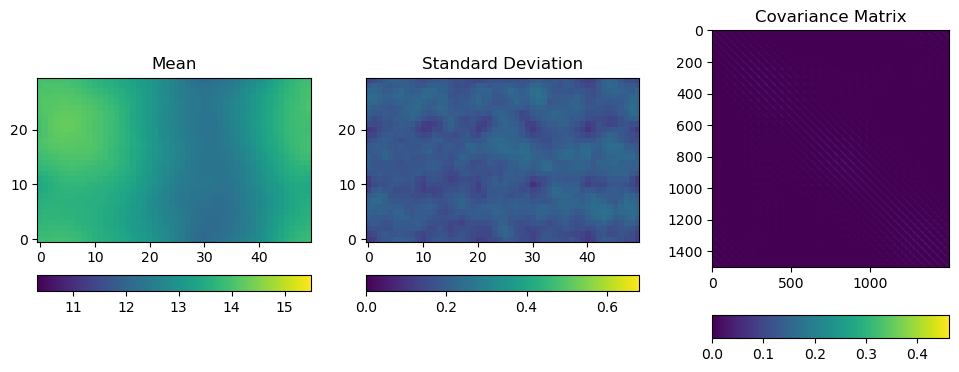

In [19]:
iewpFilter = IEWParticleFilter.IEWParticle(statistics_iewpf, observation)

for t in range(observation.N_obs):
    print(t)
    statistics_iewpf.propagate(25, model_error=False)
    iewpFilter.filter(statistics_iewpf.ensemble.ensemble, observation.obses[t])
    statistics_iewpf.plot()

## Comparison

In [20]:
from importlib import reload  
reload(Comparer)

<module 'Comparer' from '/home/florianb/advectionDiffusion/Comparer.py'>

In [21]:
comparer = Comparer.Comparer(statistics_kf, statistics_etkf, statistics_letkf, statistics_iewpf)

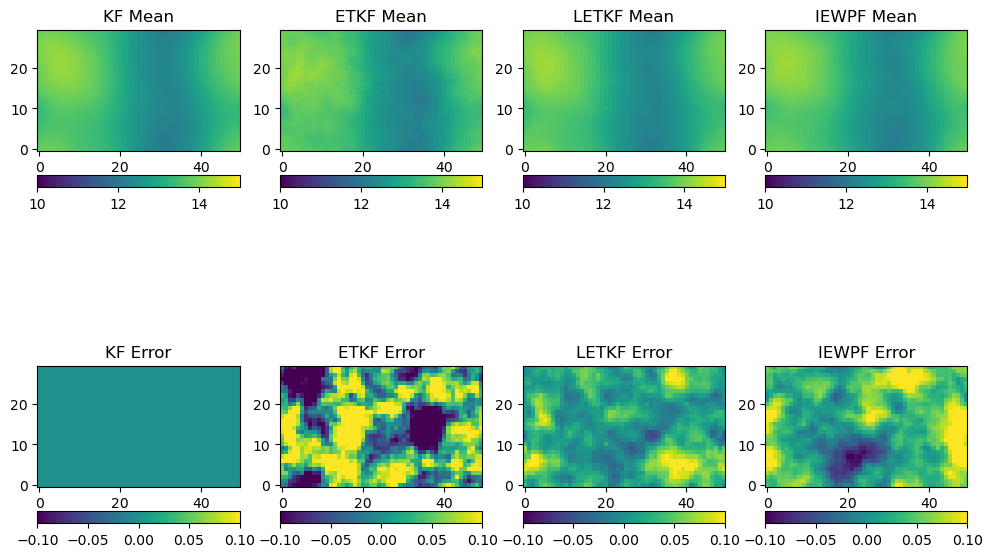

In [22]:
comparer.mean_plots()

In [23]:
mean_rmse_kf, mean_rmse_etkf, mean_rmse_letkf, mean_rmse_iewpf = comparer.mean_rmse()

print("RMSE of KF = ", mean_rmse_kf)
print("RMSE of ETKF = ", mean_rmse_etkf)
print("RMSE of LETKF = ", mean_rmse_letkf)
print("RMSE of IEWPF = ", mean_rmse_iewpf)

RMSE of KF =  0.0
RMSE of ETKF =  3.5976627612345666
RMSE of LETKF =  1.4477167079151092
RMSE of IEWPF =  2.1463846661714


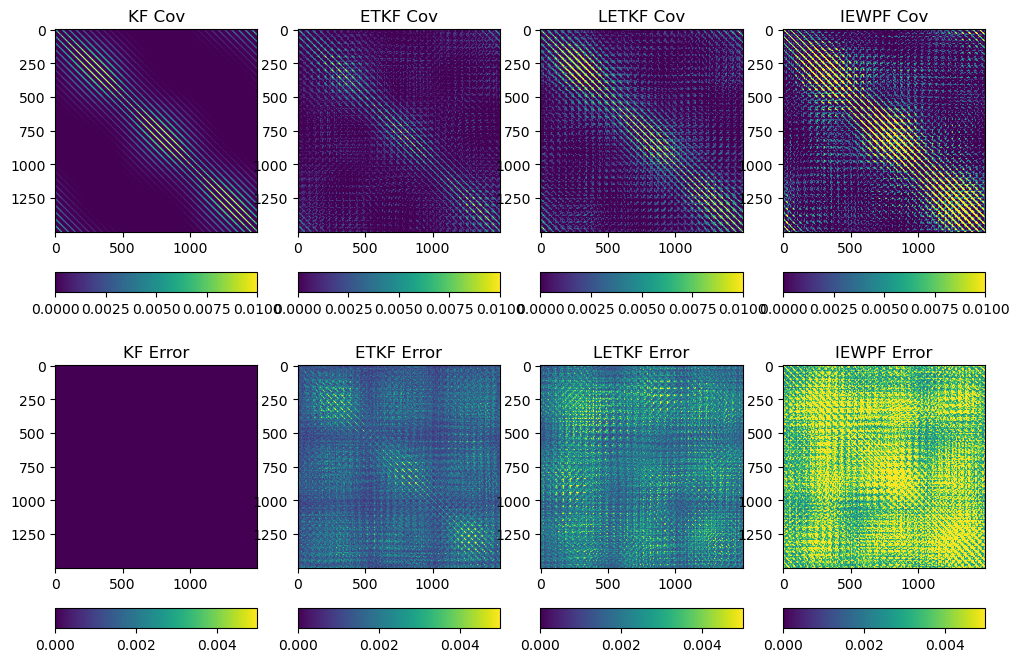

In [24]:
comparer.cov_plots()

In [25]:
cov_frob_kf, cov_frob_etkf, cov_frob_letkf, cov_frob_iewpf = comparer.cov_frobenius_dist()

print("Frobenius error in Cov matrix (KF) = ", cov_frob_kf)
print("Frobenius error in Cov matrix (ETKF) = ", cov_frob_etkf)
print("Frobenius error in Cov matrix (LETKF) = ", cov_frob_letkf)
print("Frobenius error in Cov matrix (IEWPF) = ", cov_frob_iewpf)

Frobenius error in Cov matrix (KF) =  0.0
Frobenius error in Cov matrix (ETKF) =  3.1235305333965226
Frobenius error in Cov matrix (LETKF) =  4.147007300162812
Frobenius error in Cov matrix (IEWPF) =  8.439174345246963


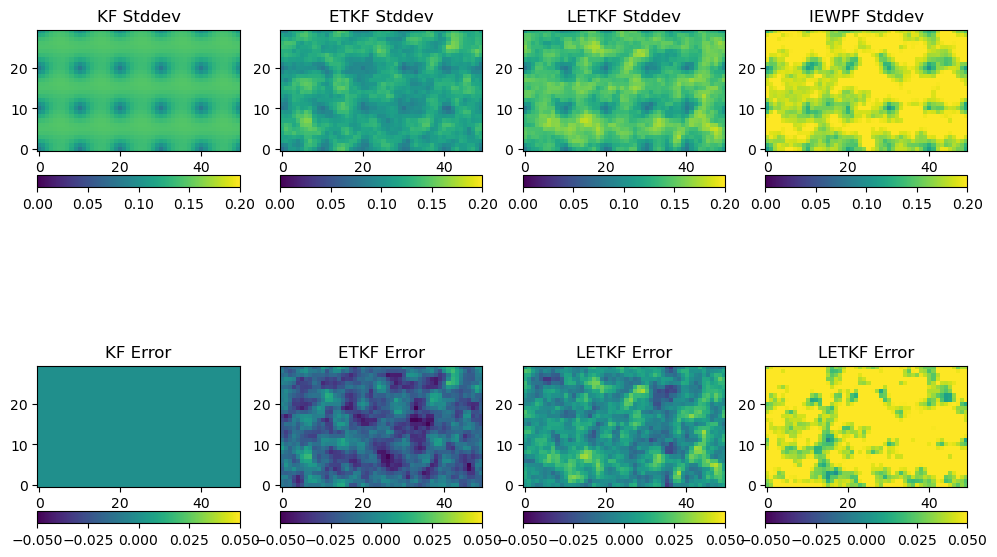

In [26]:
comparer.stddev_plots()

In [27]:
stddev_rmse_kf, stddev_rmse_etkf, stddev_rmse_letkf, stddev_rmse_iewpf = comparer.stddev_rmse()

print("RMSE of KF = ", stddev_rmse_kf)
print("RMSE of ETKF = ", stddev_rmse_etkf)
print("RMSE of LETKF = ", stddev_rmse_letkf)
print("RMSE of IEWPF = ", stddev_rmse_iewpf)

RMSE of KF =  0.0
RMSE of ETKF =  0.8298914788331878
RMSE of LETKF =  0.45812061397548687
RMSE of IEWPF =  2.2191986494558695


In [28]:
reload(Comparer)
comparer = Comparer.Comparer(statistics_kf, statistics_etkf, statistics_letkf, statistics_iewpf)

In [29]:
comparer.set_poi([0,0])
comparer.set_poi([25,15])
comparer.set_poi([1,0])

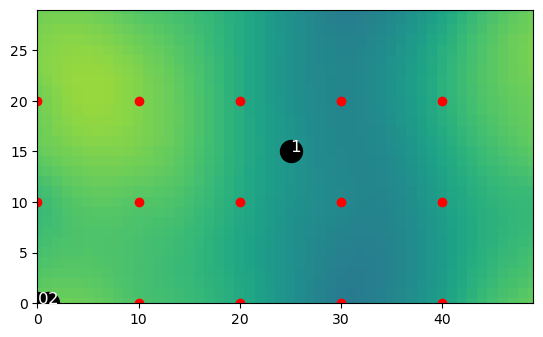

In [30]:
comparer.poi_plot(observation)

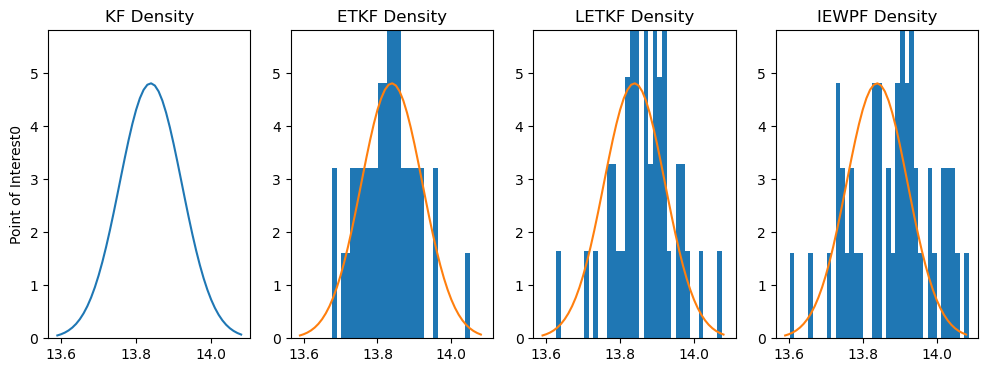

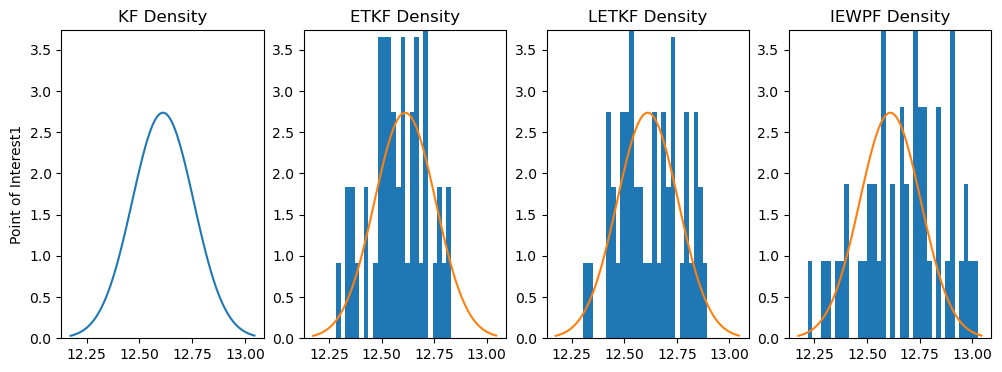

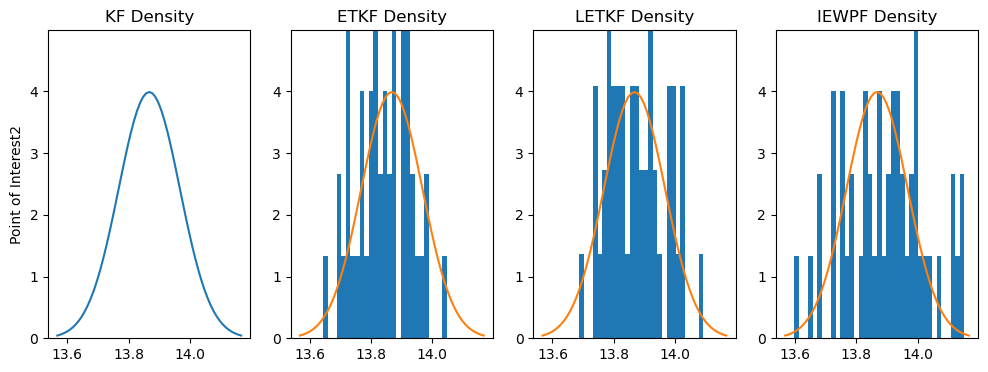

In [31]:
comparer.poi_hist(0)
comparer.poi_hist(1)
comparer.poi_hist(2)

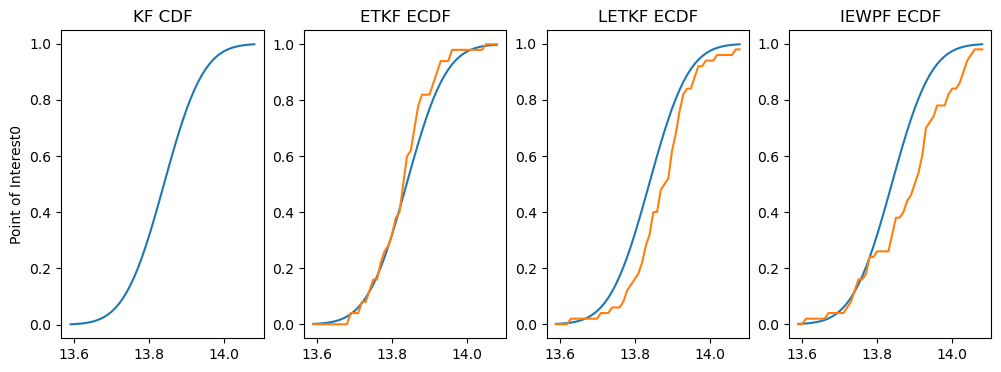

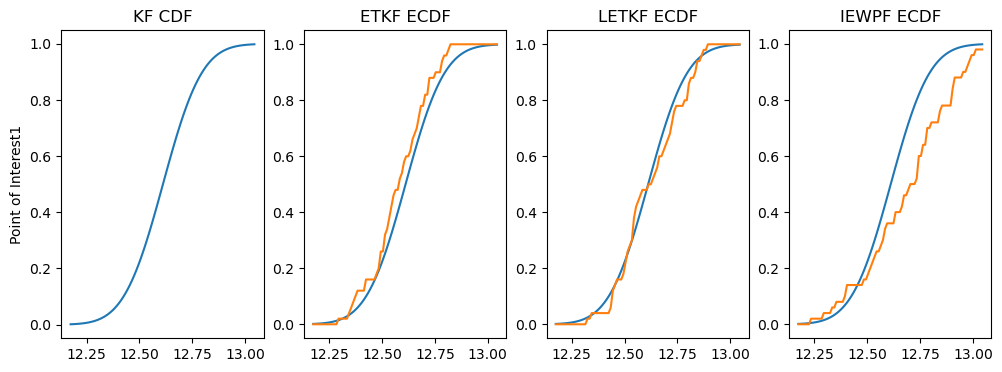

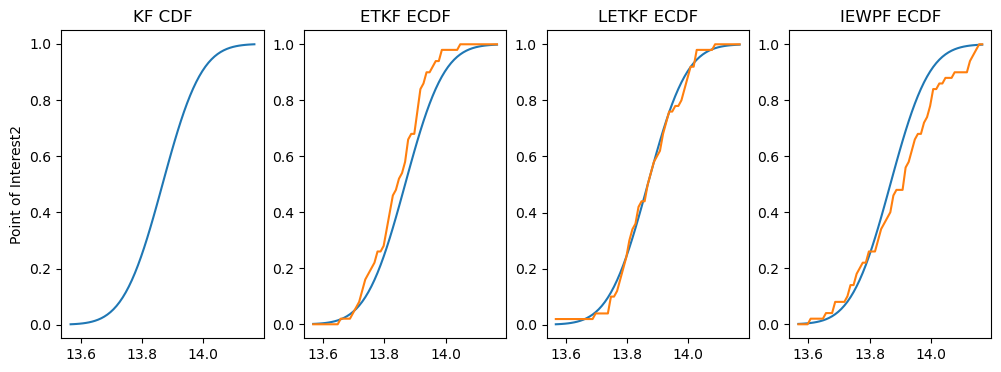

In [32]:
comparer.poi_ecdf_plots(0)
comparer.poi_ecdf_plots(1)
comparer.poi_ecdf_plots(2)

In [33]:
ecdf_err_etkf, ecdf_err_letkf, ecdf_err_iewpf = comparer.poi_ecdf_err(0)

print("Difference at pos0 (ETKF) = ", ecdf_err_etkf)
print("Difference at pos0 (LETKF) = ",ecdf_err_letkf)
print("Difference at pos0 (IEWPF) = ",ecdf_err_iewpf)

ecdf_err_etkf, ecdf_err_letkf, ecdf_err_iewpf = comparer.poi_ecdf_err(1)

print("Difference at pos1 (ETKF) = ", ecdf_err_etkf)
print("Difference at pos1 (LETKF) = ",ecdf_err_letkf)
print("Difference at pos1 (IEWPF) = ",ecdf_err_iewpf)

ecdf_err_etkf, ecdf_err_letkf, ecdf_err_iewpf = comparer.poi_ecdf_err(2)

print("Difference at pos2 (ETKF) = ", ecdf_err_etkf)
print("Difference at pos2 (LETKF) = ",ecdf_err_letkf)
print("Difference at pos2 (IEWPF) = ",ecdf_err_iewpf)

/home/florianb/advectionDiffusion/Comparer.py:353: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  ecdf_err_etkf = scipy.integrate.quad(diff_etkf, xmin, xmax, limit=100)[0]
/home/florianb/advectionDiffusion/Comparer.py:354: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and call

Difference at pos0 (ETKF) =  0.014147868457811838
Difference at pos0 (LETKF) =  0.03621971973308309
Difference at pos0 (IEWPF) =  0.04676253383668724
Difference at pos1 (ETKF) =  0.03407965658922966
Difference at pos1 (LETKF) =  0.023271957552588235
Difference at pos1 (IEWPF) =  0.08635255052574171
Difference at pos2 (ETKF) =  0.02887962087608522
Difference at pos2 (LETKF) =  0.010987193882837686
Difference at pos2 (IEWPF) =  0.03792069290441728


# Plots for paper 

In [34]:
import numpy as np
np.arange(0,1,1/50)+1/50

array([0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 , 0.22,
       0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42, 0.44,
       0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64, 0.66,
       0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86, 0.88,
       0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ])

In [35]:
table = 0

In [36]:
2+2

4